# Neighbs

In [1]:
from ipynb.fs.full.koselleck import *

[Koselleck] (11:43:04) Alles bereit 


In [2]:


def nbr(word_or_words,ntop=NBR_MAX_RANK,**wdist_opts):
    dfdists = wdist(word_or_words,**wdist_opts)
    l=[]
    for col in dfdists.columns:
        s=dfdists[col].sort_values().iloc[:ntop]
        srank=s.rank(ascending=True)
        for sword,sval,srankval in zip(s.index,s,srank):
            word,corpus,period=col.split('_')
            dx=dict(
                word=word,
                corpus=corpus,
                period=period,
                neighbor=sword,
                dist=sval,
                rank=int(srankval)
            )
            l.append(dx)
    odf=pd.DataFrame(l).query('word!=neighbor')
    odf=odf.set_index(['word','corpus','period','neighbor'])
    return odf

In [3]:
# w='culture'
# dfnbr=nbr(
#     w+',value',
#     force=False,
#     progress=1,
#     num_proc=3,
# #     ymin=1680,
# #     ymax=1960,
#     ybin=20
# )
# dfnbr

## Plotting

In [46]:
def plot_nbrs(
        word='culture',
        vnum='v20',
        min_periods=2,
        max_rank=25,
        max_rank1=5,
        width=9,
        height=6,
        save=False,
        showdata=False,
        ymin=YMIN_NBR,
        ymax=YMAX_NBR,
        ybin=YBIN_NBR,
        num_proc=2,
        num_runs=NUM_RUNS_NBR,
        progress=False,
        returndata=False,
        only_valid_words=True,
        force=False,force_data=False):
    w=word
    if save:
        ofn=f'fig.{w}.nbr.{vnum}.min_prd={min_periods}.mranks={max_rank1}_{max_rank}.png'
        ofnfn=os.path.join(PATH_FIGS,ofn)
        if not force and os.path.exists(ofnfn): return ofnfn
        
    dfres=nbr(
        w,
        num_proc=num_proc,
        progress=progress,
        only_valid_words=only_valid_words,
        ymin=ymin,ymax=ymax,ybin=ybin,
        num_runs=num_runs,force=force_data
    )
    
#     if w in set(dfres.index):
    if len(dfres):
        wdf=dfres.loc[w].reset_index().query(f'rank<={max_rank}')
        words_ever_high=set(wdf[wdf['rank']<=max_rank1].neighbor)
        figdf=wdf[wdf.neighbor.isin(words_ever_high)].groupby(
            ['period','neighbor']
        ).mean().reset_index()
        figdf['period']=[p[:5]+p[7:] for p in figdf.period]
        figdf=figdf.groupby('neighbor').filter(lambda gdf: gdf.dropna().period.nunique()>=min_periods)
        figdf=pd.concat(
            grp.assign(rank2=(grp['rank']).rank(method='first'))
            for i,grp in figdf.groupby('period')
        )
        figdf=figdf.sort_values(['period','rank'])
        if showdata: display(figdf)
        if returndata: return figdf
        print(f'Number of unique neighbors: {len(set(figdf.neighbor))}')
                        
        # start fig
        fig=start_fig(
            figdf,
            x='period',
            y='rank2',
            label='neighbor',
            figure_size=(width,height)
        ) + p9.geom_line(p9.aes(group='neighbor'),size=0.5) + p9.scale_y_reverse()

#         top_appearances=figdf.query(f'rank<={max_rank1}').sort_values('period').drop_duplicates('neighbor')
        first_appearances=figdf.loc[set(figdf.index)].sort_values('period').drop_duplicates('neighbor')
        other_appearances=figdf.loc[set(figdf.index) - set(first_appearances.index)]
        
        fig+=p9.geom_label(size=7,data=other_appearances)
        fig+=p9.geom_label(size=7,fill='#CCCCCC',fontstyle='italic',data=first_appearances)
#         fig+=p9.geom_label(size=6.5,fill='#BBBBBB',fontweight='bold',data=top_appearances)
        
        fig+=p9.scale_fill_gradient(low='white',high='#999999')
#         fig+=p9.scale_color_gradient(low='white',high='#999999')
        fig+=p9.labs(
#             title=f'Most similar words to "{w}", {ymin}-{ymax}',
            x='Date of semantic model',
            y=f'Proximity to "{w}" →',
            fill='Concreteness'
        )
        fig+=p9.theme(text=p9.element_text(size=7))
#         fig+=p9.theme(axis_text_x=p9.element_text(rotation=90))
        if save:
            fig.save(ofnfn)
            if PATH_FIGS2: fig.save(os.path.join(PATH_FIGS2,ofn))
            return ofnfn
#         display(fig)
#         return figdf
        return fig
    else:
        return f'!! {w} not in data'
    
    
# res=interact_manual(plot_nbrs)
# # res()

[Koselleck] (11:53:44) Number of unique neighbors: 26 (+15.8s)


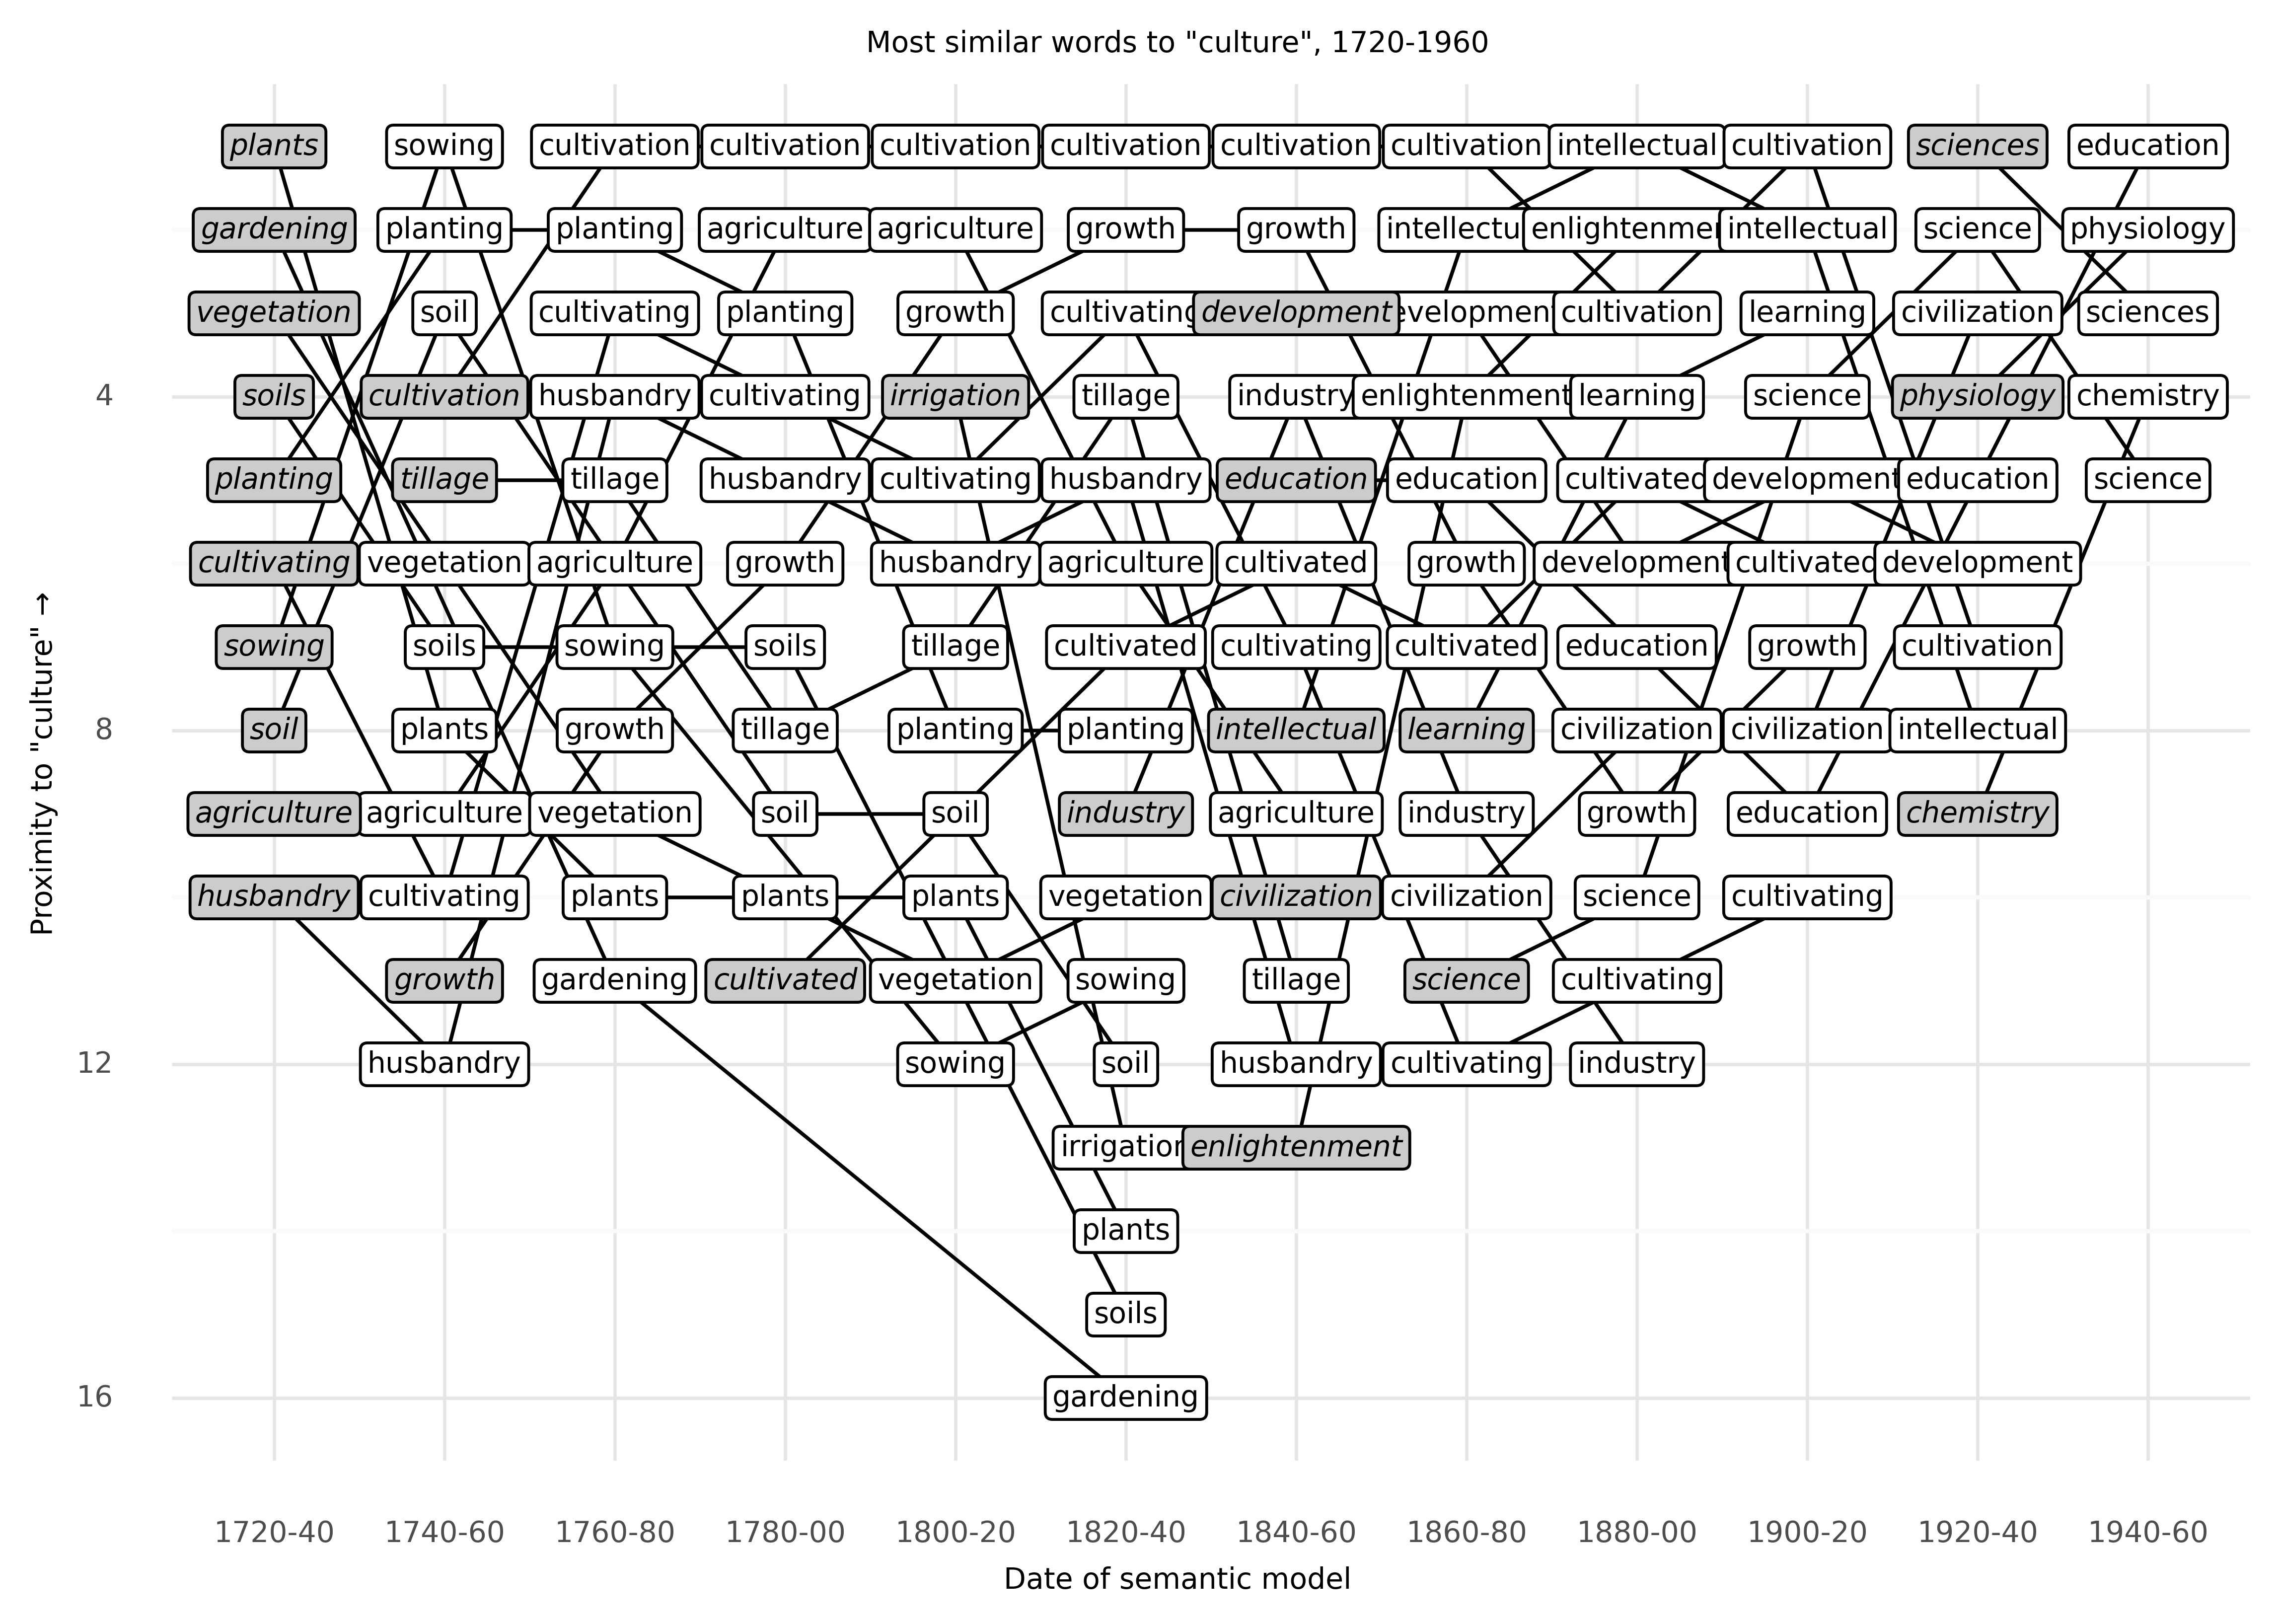

<ggplot: (8792682431392)>

In [47]:
plot_nbrs('culture')

In [45]:
def iplot_nbrs(w='labour',**attrs):    
    def go(w, save=True,**attrs):
        res=plot_nbrs(w, save=save, **attrs)
        print_img(res) if save else display(res)

    defaults=dict(
        w=w,
        min_periods=2,
        ybin=20,
        max_rank1=5,
        max_rank=25,
        ymin=fixed(1720),ymax=fixed(1900),
        returndata=fixed(False),showdata=fixed(False),
        width=fixed(8),height=fixed(5),
        save=False,force=False,force_data=False,
        num_proc=5,
        num_runs=5,
    )
    attrs={**defaults, **attrs}
    res=interact_manual_plot(go,**attrs)
    return res

In [7]:
res=iplot_nbrs('culture')

interactive(children=(Text(value='culture', description='w'), Checkbox(value=False, description='save'), IntSl…